In [14]:
from pathlib import Path
from tqdm import tqdm
import torch
from lerobot.datasets.utils import cycle

from lerobot.configs.types import FeatureType
from lerobot.datasets.lerobot_dataset import LeRobotDataset, LeRobotDatasetMetadata
from lerobot.datasets.utils import dataset_to_policy_features
from lerobot.policies.smolandfast.configuration_smolandfast import SMOLANDFASTConfig
from lerobot.policies.smolandfast.modeling_smolandfast import SMOLANDFASTPolicy

from lerobot.policies.factory import make_pre_post_processors
import matplotlib.pyplot as plt

In [2]:
output_directory = Path("outputs/train/example_pusht")
output_directory.mkdir(parents=True, exist_ok=True)

device = torch.device("cuda")

In [9]:
DATASET_PATH = "lerobot/pusht"

dataset_metadata = LeRobotDatasetMetadata(DATASET_PATH)
features = dataset_to_policy_features(dataset_metadata.features)
output_features = {key: ft for key, ft in features.items() if ft.type is FeatureType.ACTION}
input_features = {key: ft for key, ft in features.items() if key not in output_features}

cfg = SMOLANDFASTConfig(input_features=input_features,
                        output_features=output_features)

delta_timestamps = {
        "action": [i / dataset_metadata.fps for i in cfg.action_delta_indices],
    }

# We can then instantiate the dataset with these delta_timestamps configuration.
dataset = LeRobotDataset(DATASET_PATH, delta_timestamps=delta_timestamps)

dataloader = torch.utils.data.DataLoader(
    dataset,
    num_workers=0,
    batch_size=1,
    shuffle=True,
    pin_memory=device.type != "cpu",
    drop_last=True,
)
dl_iter = cycle(dataloader)


In [ ]:
policy = SMOLANDFASTPolicy(cfg,
                           dataset_stats=dataset_metadata.stats)
policy.to(device)

preprocessor, postprocessor = make_pre_post_processors(policy.config, dataset_stats=dataset.meta.stats)

In [ ]:
def distance(decoded_data, orig_data, n):
    return ((decoded_data[n, 0] - orig_data[n, 0]) ** 2 + (decoded_data[n, 1] - orig_data[n, 1]) ** 2) ** 0.5

RMSE [[1.2358099222183228, 1.1667730808258057]]%
Distance at 5th: tensor(0.0116)
Distance at 10th: tensor(0.0330)


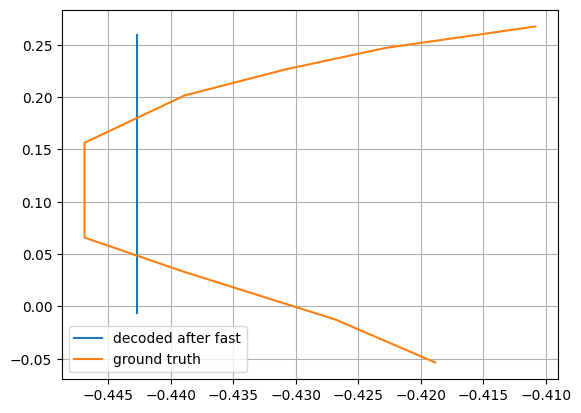

In [77]:
raw_batch = next(dl_iter)
batch = preprocessor(raw_batch)

fast_action_tokens = policy.model.fast_tokenizer(batch["action"].detach().cpu())

decoded_actions = torch.tensor(
    [
        policy.model.decode_actions_with_fast(
            [tok],
            time_horizon=policy.model.action_horizon,
            action_dim=policy.model.action_dim,
            relaxed_decoding=policy.model.config.relaxed_action_decoding,
        ).squeeze(0)
        for tok in fast_action_tokens
    ],
    dtype=torch.float32,
    device=device,
)

error:torch.tensor = torch.sqrt((decoded_actions - batch["action"])**2)

print(f"RMSE {(error.mean(dim=1)*100).tolist()}%")

decoded_data = decoded_actions.cpu()[0]
orig_data = batch["action"].cpu()[0]

print("Distance at 5th:", distance(decoded_data, orig_data, 4))
print("Distance at 10th:", distance(decoded_data, orig_data, 9))


plt.plot(decoded_data[:, 0], decoded_data[:, 1], label="decoded after fast")
plt.plot(orig_data[:, 0], orig_data[:, 1], label="ground truth")
plt.legend()
plt.grid()
plt.show()

